## CSV DATA IMPLEMENTATION

### K-Means_ADASYN_UMAP_CSVData

C:\Users\samhi\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


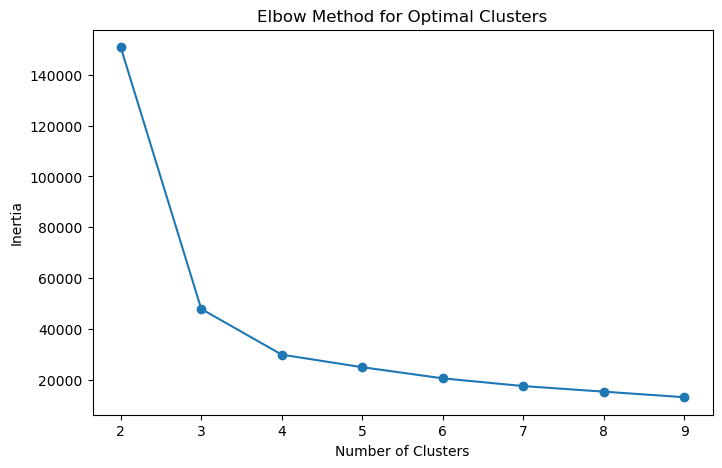

Clustering Metrics:
Silhouette Score: 0.61
Calinski-Harabasz Index: 23774.05
Davies-Bouldin Index: 0.59


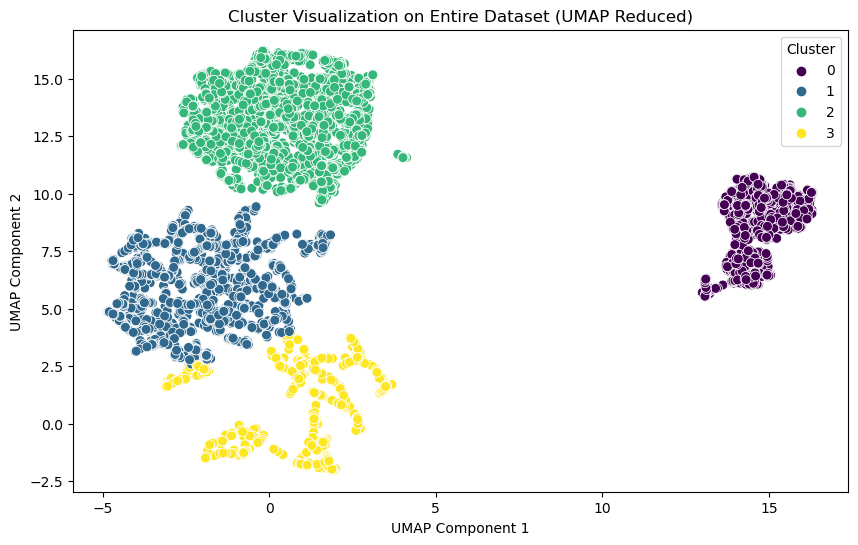

In [34]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import umap
from imblearn.over_sampling import ADASYN

# Load the dataset
data = pd.read_csv('cleaned_train.csv')

# Step 1: Filter out "Adult" category
data = data[data['age_group'] != 'Adult']

# Step 2: Ordinal encode the 'age_group' column
ordinal_encoder = OrdinalEncoder(categories=[['Child', 'Early Teen', 'Teen', 'Young Adult']])
data['age_group'] = ordinal_encoder.fit_transform(data[['age_group']])

# Drop unnecessary columns
columns_to_drop = ['id', 'sii']  # Remove unnecessary columns
data_numeric = data.drop(columns=columns_to_drop, axis=1)

# Split into features and target
X = data_numeric
y = data['sii']  # Using 'sii' for oversampling

# Step 3: ADASYN for Oversampling
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Step 4: Scaling the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Step 5: Applying UMAP for Dimensionality Reduction
umap_model = umap.UMAP(n_components=2, random_state=42)  # Reduce to 2 components
X_umap = umap_model.fit_transform(X_scaled)

# Step 6: Finding Optimal Clusters using the Elbow Method
inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_umap)
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Optimal number of clusters based on elbow curve
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

# Step 7: Fitting K-Means on the entire dataset
kmeans.fit(X_umap)
clusters = kmeans.labels_

# Step 8: Evaluating Clustering Performance
silhouette = silhouette_score(X_umap, clusters)
calinski_harabasz = calinski_harabasz_score(X_umap, clusters)
davies_bouldin = davies_bouldin_score(X_umap, clusters)

# Printing Metrics
print(f"Clustering Metrics:")
print(f"Silhouette Score: {silhouette:.2f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.2f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.2f}")

# Step 9: Visualizing Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=clusters, palette='viridis', s=50)
plt.title('Cluster Visualization on Entire Dataset (UMAP Reduced)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster')
plt.show()

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Custom transformer for visualization
class ClusterVisualizer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y=None):
        return self  # No fitting required for visualization
    
    def transform(self, X):
        # Assuming X is now UMAP transformed with clusters assigned to them
        umap_data, clusters = X[:, :-1], X[:, -1]
        
        # Plotting the clusters using seaborn
        plt.figure(figsize=(10, 6))
        sns.scatterplot(x=umap_data[:, 0], y=umap_data[:, 1], hue=clusters, palette='viridis', s=50)
        plt.title('Cluster Visualization on Entire Dataset (UMAP Reduced)')
        plt.xlabel('UMAP Component 1')
        plt.ylabel('UMAP Component 2')
        plt.legend(title='Cluster')
        plt.show()
        
        return X  # Return the transformed data unchanged

# Create the KMeans model
kmeans = KMeans(n_clusters=4, random_state=42)

# Create the UMAP model
umap_model = umap.UMAP(n_components=2, random_state=42)

# Create the pipeline with scaling, UMAP, KMeans, and visualization
kmeans_pipeline = Pipeline([
    ('scaler', StandardScaler()),  # Scaling step
    ('umap', umap_model),          # Dimensionality reduction step
    ('kmeans', kmeans),            # Clustering step
    ('visualizer', ClusterVisualizer())  # Visualization step
])

# Fit the pipeline on the data (Assuming X_resampled is your dataset after ADASYN and scaling)
kmeans_pipeline.fit(X_resampled)

# Save the pipeline to a file
joblib.dump(kmeans_pipeline, 'kmeans_model_pipeline_with_visualization.joblib')
print("Model pipeline with visualization saved as 'kmeans_model_pipeline_with_visualization.joblib'")


C:\Users\samhi\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Model pipeline with visualization saved as 'kmeans_model_pipeline_with_visualization.joblib'


### XGBoost_ADASYN_UMAP_CSVData

Accuracy: 0.56

Classification Report:
              precision    recall  f1-score   support

         0.0       0.68      0.77      0.73       305
         1.0       0.33      0.31      0.32       145
         2.0       0.34      0.23      0.27        80
         3.0       0.33      0.22      0.27         9

    accuracy                           0.56       539
   macro avg       0.42      0.38      0.40       539
weighted avg       0.53      0.56      0.54       539



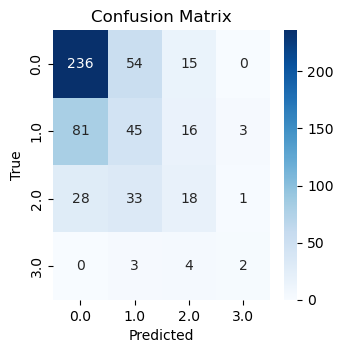

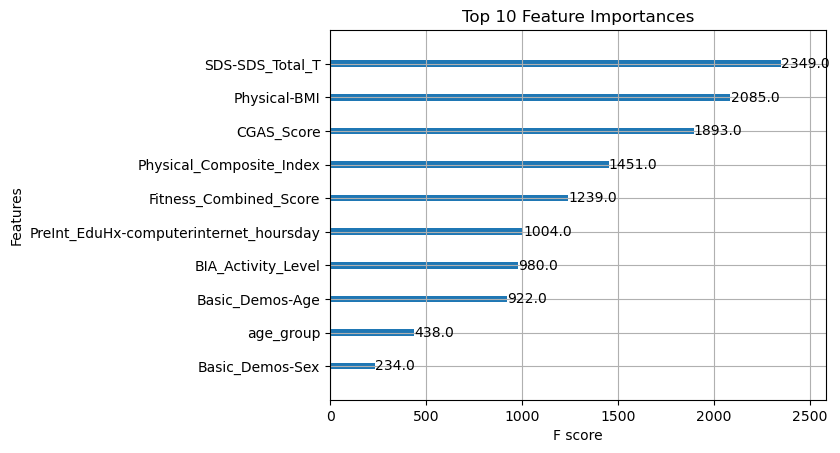

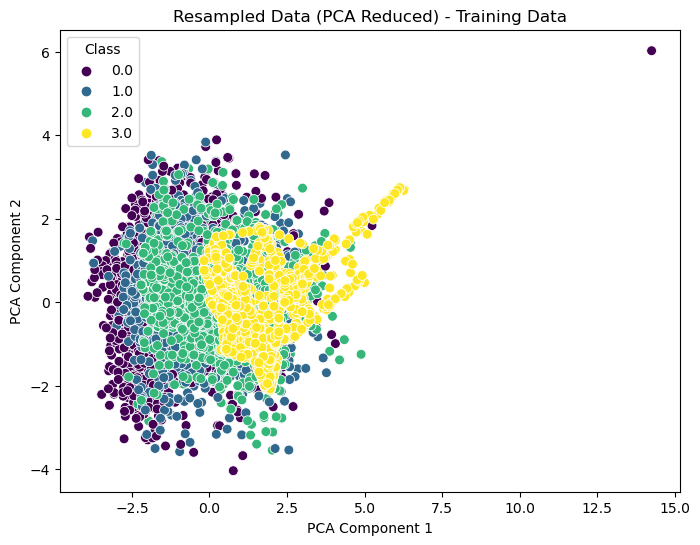

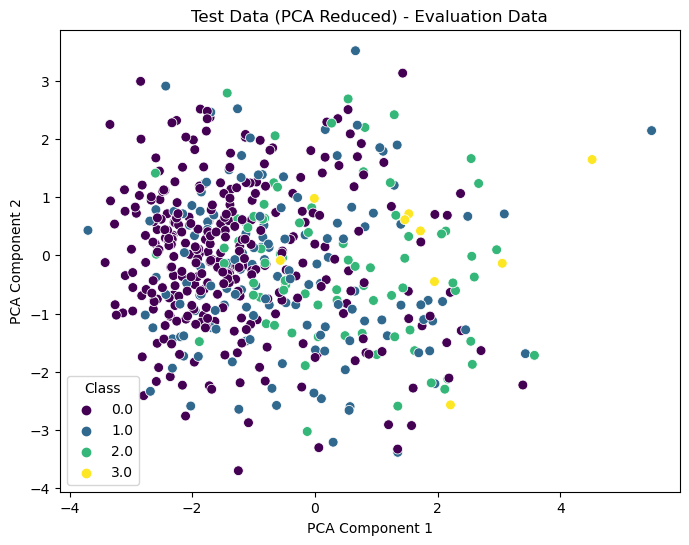


Multi-Class AUC ROC (Macro-averaged): 0.7172
AUC ROC per Class: [0.71049461 0.551129   0.71887255 0.88825996]


In [4]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from imblearn.over_sampling import ADASYN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Step 1: Prepare the Data (Assume 'data' is your DataFrame)
X = data.drop(columns=['sii', 'id'])  # Drop target and irrelevant columns
y = data['sii']  # Target variable (e.g., SII)

# Step 2: Split into Train-Test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Perform ADASYN Oversampling on the Training Data
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X_train, y_train)

# Step 4: Standardize the Data 
scaler = StandardScaler()
X_resampled_scaled = scaler.fit_transform(X_resampled)
X_test_scaled = scaler.transform(X_test)  # Apply the same transformation to test data

# Step 5: Perform PCA for Dimensionality Reduction
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
X_resampled_pca = pca.fit_transform(X_resampled_scaled)
X_test_pca = pca.transform(X_test_scaled)

# Step 6: Create and Train the XGBoost Model
# Define the model
model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, random_state=42)

# Define the parameter distribution
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 9],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Fit the model on resampled training data
model.fit(X_resampled, y_resampled)

# Step 7: Make Predictions on the Test Set
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)  # Get predicted probabilities

# Step 8: Evaluate the Model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Print classification report
print(f"\nClassification Report:\n{classification_report(y_test, y_pred)}")

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(3.5, 3.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Step 9: Feature Importance (Optional)
xgb.plot_importance(model, importance_type='weight', max_num_features=10)
plt.title('Top 10 Feature Importances')
plt.show()

# Step 10: Visualize the Resampled Data using PCA (Optional)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_resampled_pca[:, 0], y=X_resampled_pca[:, 1], hue=y_resampled, palette='viridis', s=50)
plt.title('Resampled Data (PCA Reduced) - Training Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Class')
plt.show()

# Visualize the Test Data in PCA space (Optional)
X_test_pca = pca.transform(X_test_scaled)
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=y_test, palette='viridis', s=50)
plt.title('Test Data (PCA Reduced) - Evaluation Data')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Class')
plt.show()

# Step 11: Calculate AUC ROC (One-vs-Rest)
# Binarize the true labels for multi-class AUC calculation
lb = LabelBinarizer()
y_test_bin = lb.fit_transform(y_test)  # One-hot encode the true labels

# Calculate AUC ROC for each class (one-vs-rest)
multi_class_auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro', multi_class='ovr')

print(f"\nMulti-Class AUC ROC (Macro-averaged): {multi_class_auc:.4f}")

# You can also calculate AUC ROC for each class individually
auc_per_class = roc_auc_score(y_test_bin, y_pred_proba, average=None, multi_class='ovr')
print(f"AUC ROC per Class: {auc_per_class}")

In [39]:
from sklearn.pipeline import Pipeline
import joblib

# Create a pipeline with scaling, UMAP, and XGBoost
xgb_pipeline = Pipeline([
    ('scaler', StandardScaler()),      # Scaling step
    ('umap', umap_model),              # Dimensionality reduction step
    ('xgb', xgb_model)                 # XGBoost step
])


# Save the pipeline to a file
joblib.dump(kmeans_pipeline, 'XGBoost_model_pipeline.joblib')
print("Model pipeline saved as 'XGBoost_model_pipeline.joblib'")


Model pipeline saved as 'XGBoost_model_pipeline.joblib'


### Ensemble_ADASYN_UMAP_CSVData

C:\Users\samhi\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


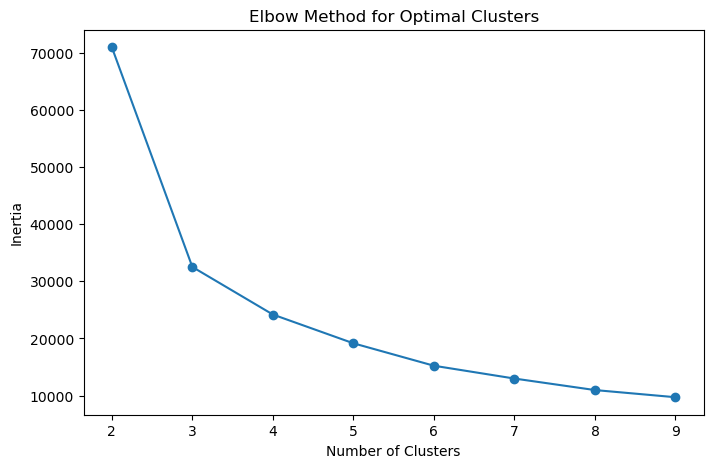

Training Data Metrics:
Silhouette Score: 0.48
Calinski-Harabasz Index: 15109.15
Davies-Bouldin Index: 0.78

Test Data Metrics:
Silhouette Score: 0.50
Calinski-Harabasz Index: 4016.64
Davies-Bouldin Index: 0.76


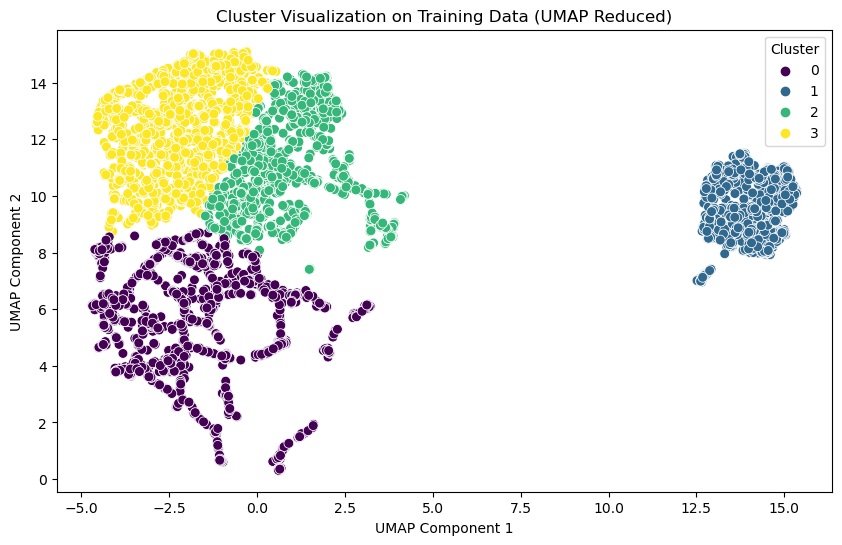

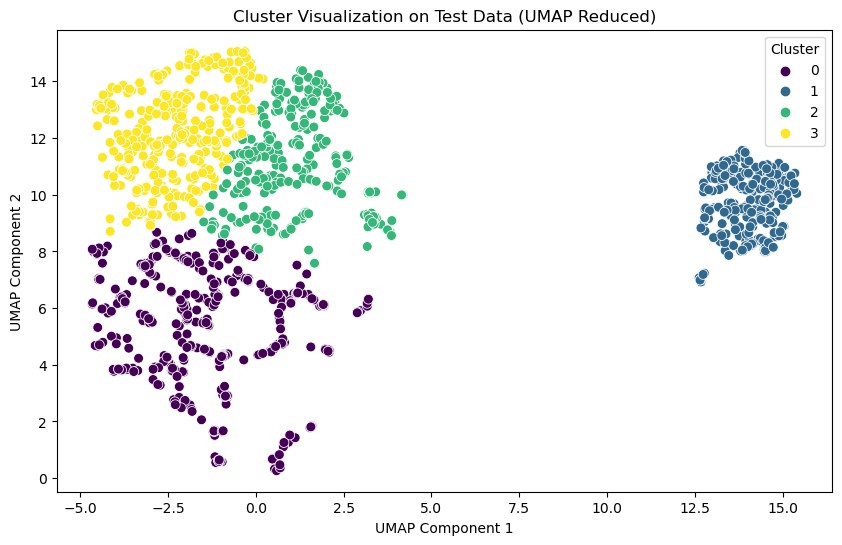

Accuracy: 0.61

Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.56      0.58       335
         1.0       0.43      0.34      0.38       290
         2.0       0.51      0.53      0.52       297
         3.0       0.79      0.95      0.86       333

    accuracy                           0.61      1255
   macro avg       0.58      0.60      0.59      1255
weighted avg       0.59      0.61      0.59      1255



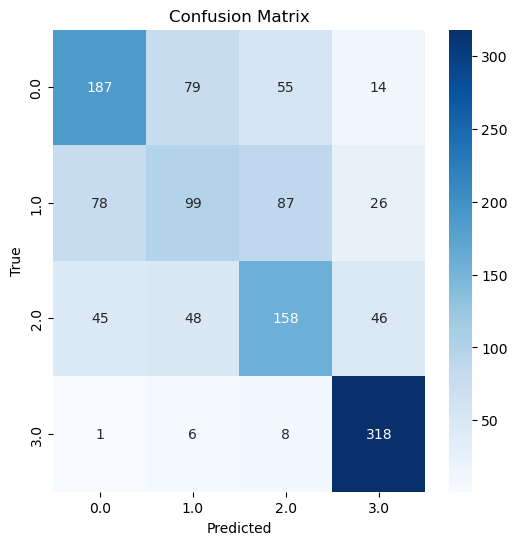

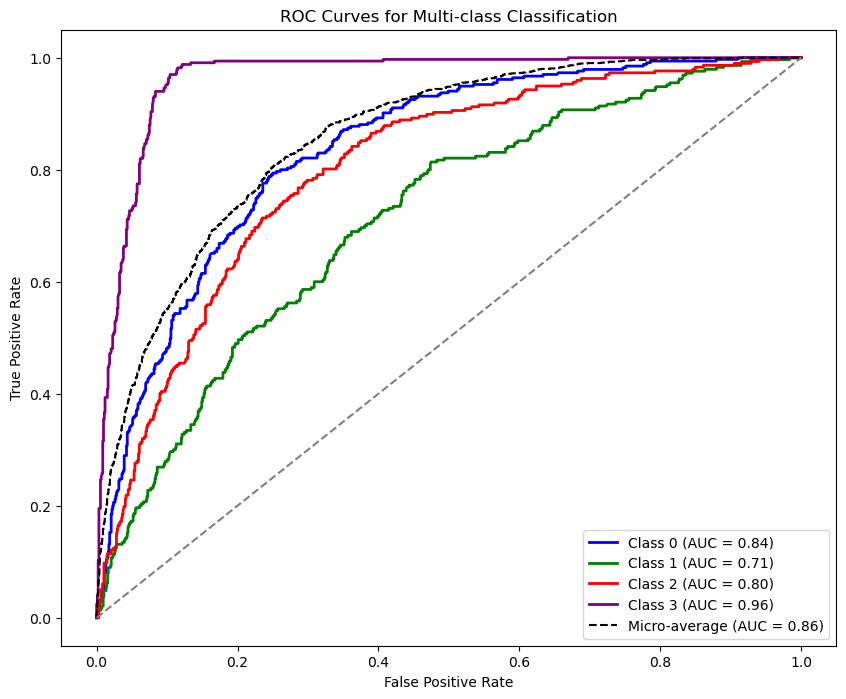

ROC AUC Scores:
Class 0: 0.84
Class 1: 0.71
Class 2: 0.80
Class 3: 0.96
Micro-average: 0.86


In [5]:
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import umap
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset
data = pd.read_csv('cleaned_train.csv')

# Step 1: Filter out "Adult" category
data = data[data['age_group'] != 'Adult']

# Step 2
# Drop unnecessary columns
columns_to_drop = ['id', 'sii', 'age_group']  # Remove unnecessary columns
data_numeric = data.drop(columns=columns_to_drop, axis=1)

# Split into features and target
X = data_numeric
y = data['sii']  # Use 'sii' for oversampling

# Step 3: Apply ADASYN for Oversampling
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Step 4: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Step 5: UMAP for Dimensionality Reduction
umap_model = umap.UMAP(n_components=2, random_state=42)  # Reduce to 2 components
X_train_umap = umap_model.fit_transform(X_train)
X_test_umap = umap_model.transform(X_test)  # Apply the same transformation to test data

# Step 6: Determine Optimal Clusters using the Elbow Method
inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_umap)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Optimal number of clusters based on elbow curve
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

# Step 7: Fit K-Means on Training Data
kmeans.fit(X_train_umap)
train_clusters = kmeans.labels_
test_clusters = kmeans.predict(X_test_umap)

# Step 8: Evaluate Clustering Performance
# Metrics for Training Data
train_silhouette = silhouette_score(X_train_umap, train_clusters)
train_calinski_harabasz = calinski_harabasz_score(X_train_umap, train_clusters)
train_davies_bouldin = davies_bouldin_score(X_train_umap, train_clusters)

print(f"Training Data Metrics:")
print(f"Silhouette Score: {train_silhouette:.2f}")
print(f"Calinski-Harabasz Index: {train_calinski_harabasz:.2f}")
print(f"Davies-Bouldin Index: {train_davies_bouldin:.2f}")

# Metrics for Test Data
test_silhouette = silhouette_score(X_test_umap, test_clusters)
test_calinski_harabasz = calinski_harabasz_score(X_test_umap, test_clusters)
test_davies_bouldin = davies_bouldin_score(X_test_umap, test_clusters)

print(f"\nTest Data Metrics:")
print(f"Silhouette Score: {test_silhouette:.2f}")
print(f"Calinski-Harabasz Index: {test_calinski_harabasz:.2f}")
print(f"Davies-Bouldin Index: {test_davies_bouldin:.2f}")

# Step 9: Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_umap[:, 0], y=X_train_umap[:, 1], hue=train_clusters, palette='viridis', s=50)
plt.title('Cluster Visualization on Training Data (UMAP Reduced)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_umap[:, 0], y=X_test_umap[:, 1], hue=test_clusters, palette='viridis', s=50)
plt.title('Cluster Visualization on Test Data (UMAP Reduced)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster')
plt.show()

# Step 10: Add KMeans Cluster Labels as Features for XGBoost
# Add the cluster labels as new features to the training and test sets
X_train_with_clusters = np.column_stack((X_train_umap, train_clusters))  # Add cluster labels to training set
X_test_with_clusters = np.column_stack((X_test_umap, test_clusters))    # Add cluster labels to test set

# Step 11: Train XGBoost Model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, random_state=42)
xgb_model.fit(X_train_with_clusters, y_train)

# Step 12: Make Predictions and Evaluate the Model
y_pred = xgb_model.predict(X_test_with_clusters)  # Predict on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Step 13: One-vs-Rest ROC AUC
# Binarize the labels for multi-class ROC
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
y_pred_proba = xgb_model.predict_proba(X_test_with_clusters)  # Predict probabilities

# Calculate ROC AUC for each class
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate micro-average ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple']
for i, color in enumerate(colors[:n_classes]):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot the micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], linestyle='--', color='black',
         label=f"Micro-average (AUC = {roc_auc['micro']:.2f})")

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
plt.title('ROC Curves for Multi-class Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Print ROC AUC for each class
print("ROC AUC Scores:")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.2f}")
print(f"Micro-average: {roc_auc['micro']:.2f}")


## ACTIGRAPHY DATA IMPLEMENTATION

### K-Means_ADASYN_UMAP_ActigraphyData

In [25]:
train=pd.read_csv(r'C:\Users\samhi\OneDrive - sjsu.edu\Documents\sjsu\Fall_24\ML\GWAR\Dataset\Actigraphy_extracted_features_Final.csv')
# Drop rows with missing values in any column
train = train.dropna()

C:\Users\samhi\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Clustering Performance Metrics:
Silhouette Score: 0.49
Calinski-Harabasz Index: 2794.94
Davies-Bouldin Index: 0.71


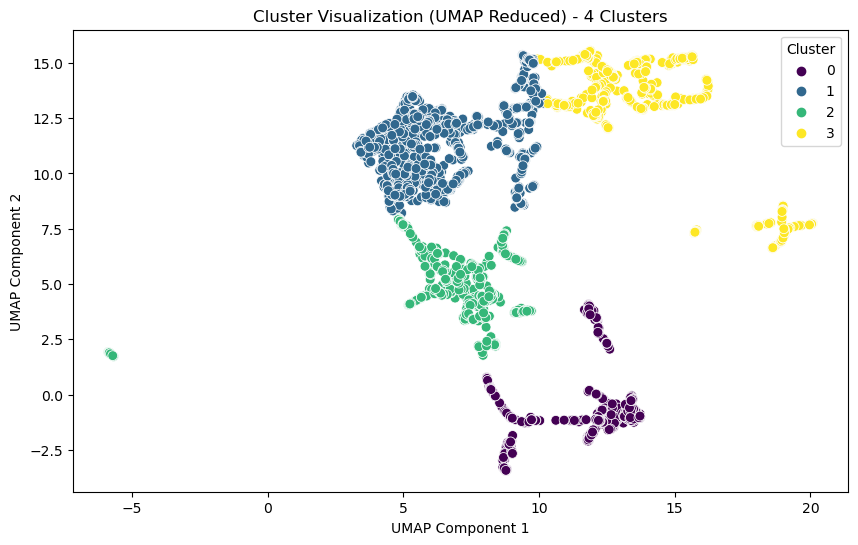

In [26]:
# Load the dataset
data = train

# Step 1: Replace 'Medium' with 1 and 'Low' with 0 in 'activity_level'
data['activity_level'] = data['activity_level'].map({'Medium': 1, 'Low': 0})

# Drop unnecessary columns
columns_to_drop = ['participant_id', 'sii']  # Remove unnecessary columns
data_numeric = data.drop(columns=columns_to_drop, axis=1)

# Features and target
X = data_numeric
y = data['sii']  # Use 'sii' for oversampling

# Step 2: Apply ADASYN for Oversampling
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Step 3: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Step 4: UMAP for Dimensionality Reduction
umap_model = umap.UMAP(n_components=2, random_state=42)  # Reduce to 2 components
X_umap = umap_model.fit_transform(X_scaled)


# Step 6: Fit K-Means on Entire Data with k=4
kmeans = KMeans(n_clusters=4, random_state=42)  # Set k=4
kmeans.fit(X_umap)
clusters = kmeans.labels_

# Step 7: Evaluate Clustering Performance
# Metrics for the entire dataset
silhouette = silhouette_score(X_umap, clusters)
calinski_harabasz = calinski_harabasz_score(X_umap, clusters)
davies_bouldin = davies_bouldin_score(X_umap, clusters)

# Print Metrics
print(f"Clustering Performance Metrics:")
print(f"Silhouette Score: {silhouette:.2f}")
print(f"Calinski-Harabasz Index: {calinski_harabasz:.2f}")
print(f"Davies-Bouldin Index: {davies_bouldin:.2f}")

# Step 8: Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=clusters, palette='viridis', s=50)
plt.title('Cluster Visualization (UMAP Reduced) - 4 Clusters')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster')
plt.show()


### XGBoost_ADASYN_UMAP_ActigraphyData

C:\Users\samhi\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
C:\Users\samhi\anaconda3\lib\site-packages\xgboost\core.py:158: UserWarning: [20:32:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.65      0.65       116
         1.0       0.73      0.61      0.66       126
         2.0       0.78      0.89      0.83       114
         3.0       0.97      1.00      0.99       110

    accuracy                           0.78       466
   macro avg       0.78      0.79      0.78       466
weighted avg       0.78      0.78      0.78       466

Accuracy: 0.78
Micro-average ROC AUC Score: 0.93


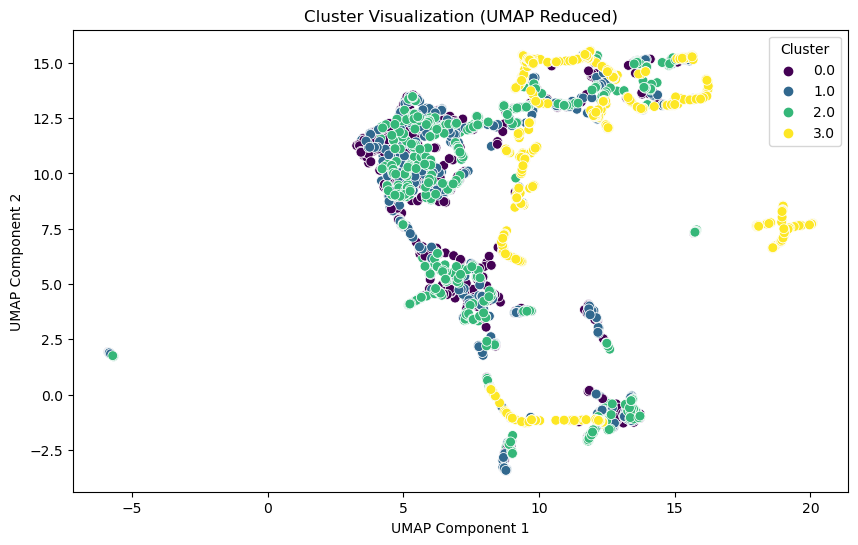

In [27]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score
from imblearn.over_sampling import ADASYN
import umap
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# Step 2: Apply ADASYN for Oversampling
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Step 3: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Step 4: UMAP for Dimensionality Reduction (Optional, if needed for visualization)
umap_model = umap.UMAP(n_components=2, random_state=42)  # Reduce to 2 components
X_umap = umap_model.fit_transform(X_scaled)

# Step 5: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Step 6: Define and Train XGBoost Classifier
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

# Step 7: Evaluate the Model
y_pred = xgb.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy:.2f}")

# Compute ROC AUC for each class
y_proba = xgb.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_proba, multi_class='ovr')
print(f"Micro-average ROC AUC Score: {roc_auc:.2f}")

# Step 8: Visualize UMAP Clusters (Optional)
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=y_resampled, palette='viridis', s=50)
plt.title('Cluster Visualization (UMAP Reduced)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster')
plt.show()


C:\Users\samhi\anaconda3\lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


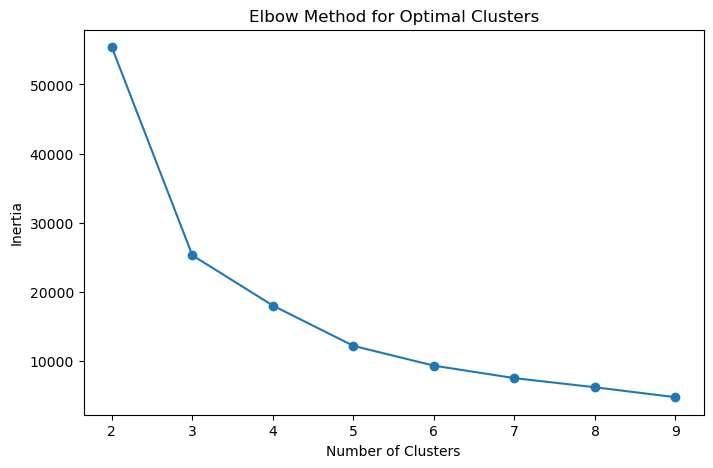

Training Data Metrics:
Silhouette Score: 0.50
Calinski-Harabasz Index: 2880.46
Davies-Bouldin Index: 0.81

Test Data Metrics:
Silhouette Score: 0.51
Calinski-Harabasz Index: 759.34
Davies-Bouldin Index: 0.78


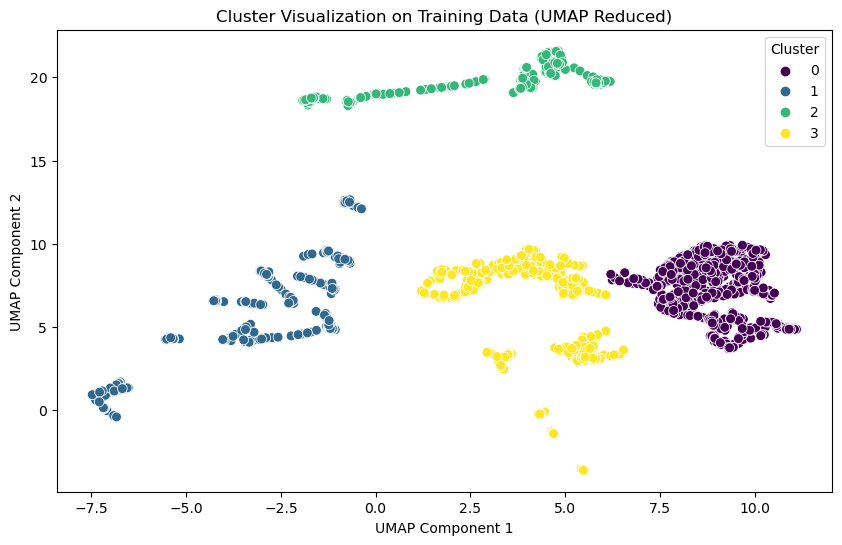

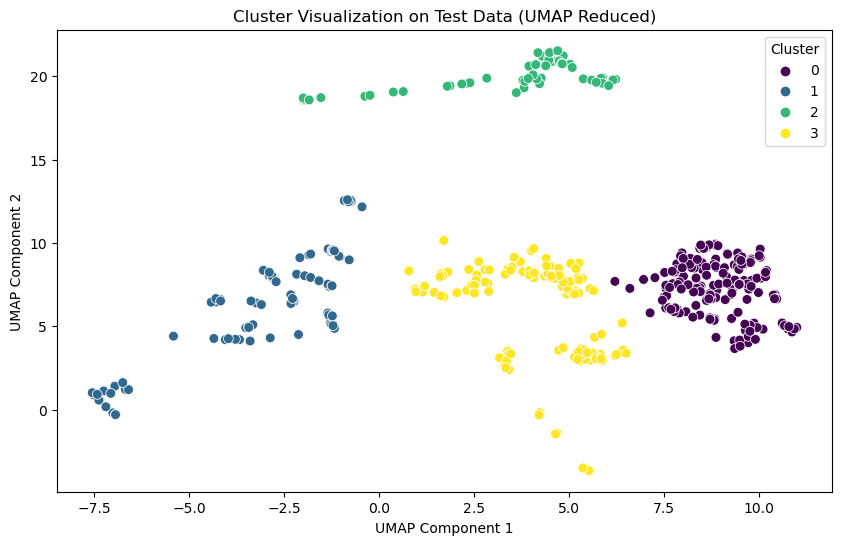

Accuracy: 0.82

Classification Report:
              precision    recall  f1-score   support

         0.0       0.79      0.74      0.76       128
         1.0       0.72      0.71      0.71       121
         2.0       0.81      0.87      0.84       114
         3.0       0.99      0.99      0.99       112

    accuracy                           0.82       475
   macro avg       0.83      0.83      0.83       475
weighted avg       0.82      0.82      0.82       475



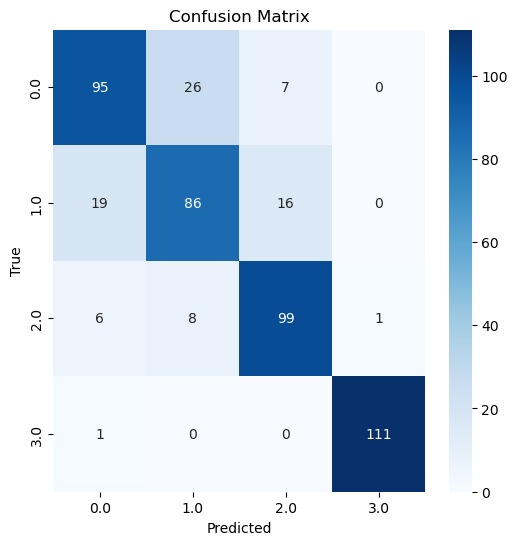

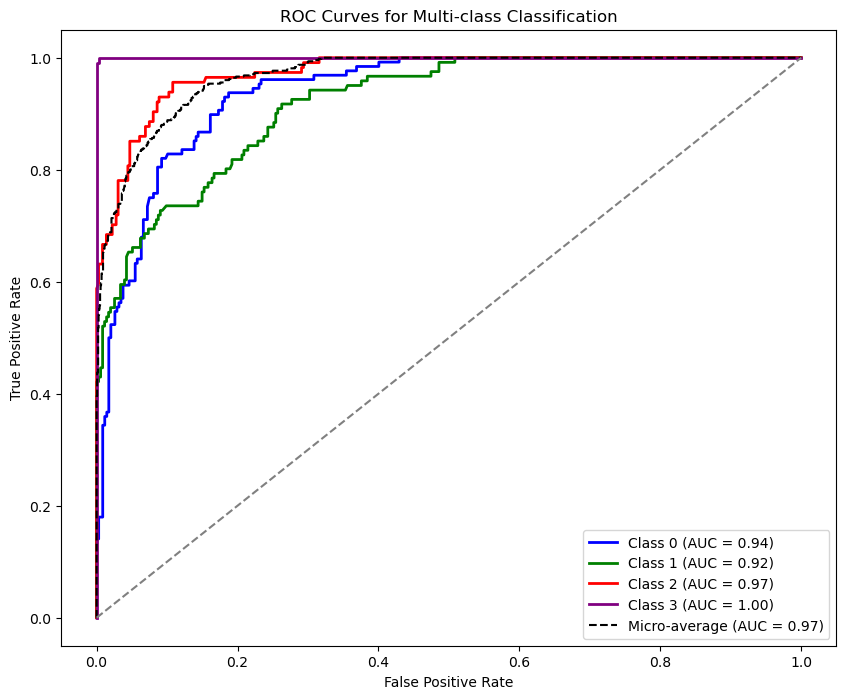

ROC AUC Scores:
Class 0: 0.94
Class 1: 0.92
Class 2: 0.97
Class 3: 1.00
Micro-average: 0.97


In [29]:
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.cluster import KMeans
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import umap
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the dataset
data = train

# Step 2
# Drop unnecessary columns
columns_to_drop = ['participant_id']  # Remove unnecessary columns
data_numeric = data.drop(columns=columns_to_drop, axis=1)

# Split into features and target
X = data_numeric
y = data['sii']  # Use 'sii' for oversampling

# Step 3: Apply ADASYN for Oversampling
adasyn = ADASYN(random_state=42)
X_resampled, y_resampled = adasyn.fit_resample(X, y)

# Step 4: Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_resampled)

# Train-Test Split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_resampled, test_size=0.2, random_state=42)

# Step 5: UMAP for Dimensionality Reduction
umap_model = umap.UMAP(n_components=2, random_state=42)  # Reduce to 2 components
X_train_umap = umap_model.fit_transform(X_train)
X_test_umap = umap_model.transform(X_test)  # Apply the same transformation to test data

# Step 6: Determine Optimal Clusters using the Elbow Method
inertia = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_train_umap)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

# Optimal number of clusters based on elbow curve
optimal_k = 4
kmeans = KMeans(n_clusters=optimal_k, random_state=42)

# Step 7: Fit K-Means on Training Data
kmeans.fit(X_train_umap)
train_clusters = kmeans.labels_
test_clusters = kmeans.predict(X_test_umap)

# Step 8: Evaluate Clustering Performance
# Metrics for Training Data
train_silhouette = silhouette_score(X_train_umap, train_clusters)
train_calinski_harabasz = calinski_harabasz_score(X_train_umap, train_clusters)
train_davies_bouldin = davies_bouldin_score(X_train_umap, train_clusters)

print(f"Training Data Metrics:")
print(f"Silhouette Score: {train_silhouette:.2f}")
print(f"Calinski-Harabasz Index: {train_calinski_harabasz:.2f}")
print(f"Davies-Bouldin Index: {train_davies_bouldin:.2f}")

# Metrics for Test Data
test_silhouette = silhouette_score(X_test_umap, test_clusters)
test_calinski_harabasz = calinski_harabasz_score(X_test_umap, test_clusters)
test_davies_bouldin = davies_bouldin_score(X_test_umap, test_clusters)

print(f"\nTest Data Metrics:")
print(f"Silhouette Score: {test_silhouette:.2f}")
print(f"Calinski-Harabasz Index: {test_calinski_harabasz:.2f}")
print(f"Davies-Bouldin Index: {test_davies_bouldin:.2f}")

# Step 9: Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_umap[:, 0], y=X_train_umap[:, 1], hue=train_clusters, palette='viridis', s=50)
plt.title('Cluster Visualization on Training Data (UMAP Reduced)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_test_umap[:, 0], y=X_test_umap[:, 1], hue=test_clusters, palette='viridis', s=50)
plt.title('Cluster Visualization on Test Data (UMAP Reduced)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.legend(title='Cluster')
plt.show()

# Step 10: Add KMeans Cluster Labels as Features for XGBoost
# Add the cluster labels as new features to the training and test sets
X_train_with_clusters = np.column_stack((X_train_umap, train_clusters))  # Add cluster labels to training set
X_test_with_clusters = np.column_stack((X_test_umap, test_clusters))    # Add cluster labels to test set

# Step 11: Train XGBoost Model
xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=4, random_state=42)
xgb_model.fit(X_train_with_clusters, y_train)

# Step 12: Make Predictions and Evaluate the Model
y_pred = xgb_model.predict(X_test_with_clusters)  # Predict on the test set
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Step 13: One-vs-Rest ROC AUC
# Binarize the labels for multi-class ROC
y_test_binarized = label_binarize(y_test, classes=np.unique(y))
y_pred_proba = xgb_model.predict_proba(X_test_with_clusters)  # Predict probabilities

# Calculate ROC AUC for each class
n_classes = y_test_binarized.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Calculate micro-average ROC AUC
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_binarized.ravel(), y_pred_proba.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot the ROC curves for each class
plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'purple']
for i, color in enumerate(colors[:n_classes]):
    plt.plot(fpr[i], tpr[i], color=color, lw=2, label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

# Plot the micro-average ROC curve
plt.plot(fpr["micro"], tpr["micro"], linestyle='--', color='black',
         label=f"Micro-average (AUC = {roc_auc['micro']:.2f})")

plt.plot([0, 1], [0, 1], color="gray", linestyle="--")  # Diagonal line
plt.title('ROC Curves for Multi-class Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Print ROC AUC for each class
print("ROC AUC Scores:")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.2f}")
print(f"Micro-average: {roc_auc['micro']:.2f}")


In [33]:
import joblib

# Wrap trained components in a dictionary
model_pipeline = {
    'scaler': scaler,
    'umap': umap_model,
    'kmeans': kmeans,
    'xgb_model': xgb_model
}

# Save the pipeline to a file
joblib.dump(model_pipeline, 'Ensemble_model_pipeline.joblib')
print("Model pipeline has been saved successfully.")


Model pipeline has been saved successfully.
